## Convolution
The universal approximation theorem states that we can in principle approximate any ground truth function. In practice, this is difficult. We have a powerful optimization method with SGD and momentum, but processing complex data types such as images was historically not really possible until convolution became a thing. Convolution stems from traditional image processing techniques over convolutional kernels (not similar to general kernel functions like the RBF kernels). Instead of defining specific kernels beforehand, convolutional layers allow a network to learn the kernels that fit the specific task and data.   


### 2D Convolution
```{prf:definition}
Given a matrix $X\in\mathbb{R}^{d_h\times d_w}$ representing for example an image. Let $K\in\mathbb{R}^{\kappa\times \kappa}$ be the convolution kernel (filter). The output of a convolution is then defined as the matrix $O\in\mathcal{R}^{d_h-k+1\times d_w-k+1}$ whose entries are given by
\begin{align*}
O_{ij} = (X \star K)_{ij} = \sum_{i_k=0}^{k-1}\sum_{j_k=0}^{k-1} X_{i+i_k,j+j_k} K_{i_k,j_k}
\end{align*}
```
In a 2D convolution, a small kernel (also called a filter) is slid across the input image. The kernel acts like a template. At each location, an operation that can be expressed as an  inner product between the flattened kernel and an image patch, measures how similar the local patch is to that template.
This makes convolution useful for feature detection — each filter is tuned to respond to specific visual patterns (like edges, textures, corners).      

The plot below visualizes the 2D convolution operation. The matrix on the left can be interpreted as the image, the matrix in the middle is the kernel and the matrix on the left is the output.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
cm_1 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#ffa1cf"])
cm_2 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#f37726"])
#####################
# Array preparation
#####################

#input array
a = np.random.randint(1,10, size=(5,5))
# kernel
kernel = np.array([[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]])

# visualization array (2 bigger in each direction)
va = np.zeros((a.shape[0], a.shape[1]), dtype=int)
va = a

#output array
res = np.zeros((a.shape[0]-kernel.shape[0]+1,a.shape[1]-kernel.shape[1]+1))

#colorarray
va_color = np.zeros((a.shape[0], a.shape[1])) 

#####################
# Create inital plot
#####################
fig = plt.figure(figsize=(10,3))

def add_axes_inches(fig, rect):
    w,h = fig.get_size_inches()
    return fig.add_axes([rect[0]/(w+2), rect[1]/(h+2), rect[2]/(w+2), rect[3]/(h+2)])

axwidth = 3.
cellsize = axwidth/va.shape[1]
axheight = cellsize*va.shape[0]

ax_va  = add_axes_inches(fig, [cellsize, cellsize, axwidth, axheight])
ax_kernel  = add_axes_inches(fig, [cellsize*2+axwidth,
                                   (2+res.shape[0])*cellsize-kernel.shape[0]*cellsize,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_res = add_axes_inches(fig, [cellsize*3+axwidth+kernel.shape[1]*cellsize,
                               2*cellsize, 
                               res.shape[1]*cellsize,  
                               res.shape[0]*cellsize])
ax_kernel.set_title("Kernel", size=12)

im_va = ax_va.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_0)
for i in range(va.shape[0]):
    for j in range(va.shape[1]):
        ax_va.text(j,i, va[i,j], va="center", ha="center")

ax_kernel.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_2)
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax_kernel.text(j,i, kernel[i,j], va="center", ha="center")


im_res = ax_res.imshow(res, vmin=0, vmax=1.3, cmap=cm_1)
res_texts = []
for i in range(res.shape[0]):
    row = []
    for j in range(res.shape[1]):
        row.append(ax_res.text(j,i, "", va="center", ha="center"))
    res_texts.append(row)    


for ax  in [ax_va, ax_kernel, ax_res]:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.yaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.xaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.grid(color="k")

###############
# Animation
###############
def init():
    for row in res_texts:
        for text in row:
            text.set_text("")

def animate(ij):
    i,j=ij
    o = kernel.shape[1]//2
    # calculate result
    res_ij = (kernel*va[i-o+1:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_texts[i][j].set_text(res_ij)
    # make colors
    c = va_color.copy()
    c[1+i-o:1+i+o+1, 1+j-o:1+j+o+1] = 1.
    im_va.set_array(c)

    r = res.copy()
    r[i,j] = 1
    im_res.set_array(r)

i,j = np.indices(res.shape)
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, 
                                         frames=zip(i.flat, j.flat), interval=400)
plt.close()
HTML(anim.to_jshtml())

The images below visualize how a kernel acts as a filter of specific features. The kernel below has the form 
$$\begin{pmatrix}-1&-1&-1\\0&0&0\\1&1&1\end{pmatrix}$$
and it is used to detect horizontal edges. An edge that has a dark color above and a light color below results in a light line, whereas an edge that has a dark color below and a light color above results in a dark line.

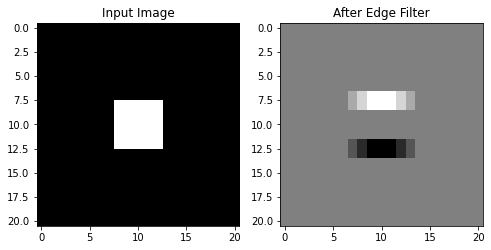

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Create a simple 7x7 grayscale "image"
image = torch.zeros(1, 1, 21, 21)  # (batch, channels, height, width)
image[0, 0, 8:13, 8:13] = 1.0      # A white square in the center

# Define a simple edge-detection kernel
edge_filter = torch.tensor([[[[-1, -1, -1],
                              [ 0,  0,  0],
                              [ 1,  1,  1]]]], dtype=torch.float32)

# Apply convolution manually
conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
conv.weight.data = edge_filter  # Set weights to our kernel
output = conv(image)

# Plot input and output
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image[0, 0].numpy(), cmap='gray')
axes[0].set_title("Input Image")
axes[1].imshow(output[0, 0].detach().numpy(), cmap='gray')
axes[1].set_title("After Horizontal Edge Filter")
plt.show()


The images below show how this filter works on an actual image.

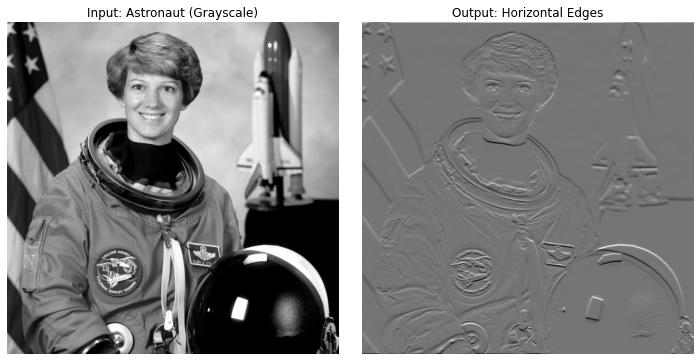

In [84]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import data, color
from PIL import Image
import torchvision.transforms as transforms

# Load astronaut image and convert to grayscale
astro_rgb = data.astronaut()                 # shape (H, W, 3)
astro_gray = color.rgb2gray(astro_rgb)       # float64, shape (H, W), values in [0, 1]

# Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # shape: (1, H, W)
])
astro_gray = astro_gray.astype('float32')  # Convert to float32
image_tensor = torch.from_numpy(astro_gray).unsqueeze(0).unsqueeze(0)  # shape (1, 1, H, W)


# Define horizontal edge-detection kernel
edge_filter = torch.tensor([[[[-1, -1, -1],
                              [ 0,  0,  0],
                              [ 1,  1,  1]]]], dtype=torch.float32)

# Create conv layer with custom filter
conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
conv.weight.data = edge_filter

# Apply convolution
with torch.no_grad():
    output = conv(image_tensor)

# Plot input and filtered output
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_tensor[0, 0], cmap='gray')
axes[0].set_title("Input: Astronaut (Grayscale)")
axes[0].axis('off')

axes[1].imshow(output[0, 0], cmap='gray')
axes[1].set_title("Output: Horizontal Edges")
axes[1].axis('off')

plt.tight_layout()
plt.show()


#### Stride and Padding
The are two notable variants of the vanilla convolution approach: those that use padding and/or stride. These parameters control the spatial size of the output and the receptive field of the convolution.

The stride controls how much the kernel shifts at each step.

- Stride = 1: standard behavior — the kernel moves one pixel at a time.
- Stride > 1: the kernel moves in larger jumps — this downsamples the output.

Using a stride larger than one reduces spatial resolution. The example below shows a convolution with a stride of two.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
cm_1 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#ffa1cf"])
cm_2 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#f37726"])
#####################
# Array preparation
#####################

#input array
a = np.random.randint(1,10, size=(5,5))
# kernel
kernel = np.array([[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]])

# visualization array (2 bigger in each direction)
va = np.zeros((a.shape[0], a.shape[1]), dtype=int)
va = a

#output array
res = np.zeros((a.shape[0]-kernel.shape[0],a.shape[1]-kernel.shape[1]))

#colorarray
va_color = np.zeros((a.shape[0], a.shape[1])) 

#####################
# Create inital plot
#####################
fig = plt.figure(figsize=(10,3))

def add_axes_inches(fig, rect):
    w,h = fig.get_size_inches()
    return fig.add_axes([rect[0]/(w+2), rect[1]/(h+2), rect[2]/(w+2), rect[3]/(h+2)])

axwidth = 3.
cellsize = axwidth/va.shape[1]
axheight = cellsize*va.shape[0]

ax_va  = add_axes_inches(fig, [cellsize, cellsize, axwidth, axheight])
ax_kernel  = add_axes_inches(fig, [cellsize*2+axwidth,
                                   (2+res.shape[0])*cellsize-kernel.shape[0]*cellsize,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_res = add_axes_inches(fig, [cellsize*3+axwidth+kernel.shape[1]*cellsize,
                               2*cellsize, 
                               res.shape[1]*cellsize,  
                               res.shape[0]*cellsize])
ax_kernel.set_title("Kernel", size=12)

im_va = ax_va.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_0)
for i in range(va.shape[0]):
    for j in range(va.shape[1]):
        ax_va.text(j,i, va[i,j], va="center", ha="center")

ax_kernel.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_2)
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax_kernel.text(j,i, kernel[i,j], va="center", ha="center")


im_res = ax_res.imshow(res, vmin=0, vmax=1.3, cmap=cm_1)
res_texts = []
for i in range(res.shape[0]):
    row = []
    for j in range(res.shape[1]):
        row.append(ax_res.text(j,i, "", va="center", ha="center"))
    res_texts.append(row)    


for ax  in [ax_va, ax_kernel, ax_res]:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.yaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.xaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.grid(color="k")

###############
# Animation
###############
def init():
    for row in res_texts:
        for text in row:
            text.set_text("")

def animate(ij):
    i,j=ij
    o = kernel.shape[1]//2
    # calculate result
    res_ij = (kernel*va[2*i-o+1:1+2*i+o+1, 1+2*j-o:1+2*j+o+1]).sum()
    res_texts[i][j].set_text(res_ij)
    # make colors
    c = va_color.copy()
    c[1+2*i-o:1+2*i+o+1, 1+2*j-o:1+2*j+o+1] = 1.
    im_va.set_array(c)

    r = res.copy()
    r[i,j] = 1
    im_res.set_array(r)

i,j = np.indices(res.shape)
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, 
                                         frames=zip(i.flat, j.flat), interval=400)
plt.close()
HTML(anim.to_jshtml())

Padding adds extra rows/columns around the input to the preserve the size of the input or control edge behavior. 
- Padding = 0: vanilla convolution, reduces the size of the output 
- Padding >0 : results in an output size of $H-k + 2p+1$ ($p$ is the padding size) 

The example below shows a convolution with padding =1 and kernel of size $3\times 3$ which preserves the size of the input. 

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
cm_1 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#ffa1cf"])
cm_2 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#f37726"])
#####################
# Array preparation
#####################

#input array
a = np.random.randint(50,150, size=(5,5))
# kernel
kernel = np.array([[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]])

# visualization array (2 bigger in each direction)
va = np.zeros((a.shape[0]+2, a.shape[1]+2), dtype=int)
va[1:-1,1:-1] = a

#output array
res = np.zeros_like(a)

#colorarray
va_color = np.zeros((a.shape[0]+2, a.shape[1]+2)) 
va_color[1:-1,1:-1] = 0.5

#####################
# Create inital plot
#####################
fig = plt.figure(figsize=(8,4))

def add_axes_inches(fig, rect):
    w,h = fig.get_size_inches()
    return fig.add_axes([rect[0]/w, rect[1]/h, rect[2]/w, rect[3]/h])

axwidth = 3.
cellsize = axwidth/va.shape[1]
axheight = cellsize*va.shape[0]

ax_va  = add_axes_inches(fig, [cellsize, cellsize, axwidth, axheight])
ax_kernel  = add_axes_inches(fig, [cellsize*2+axwidth,
                                   (2+res.shape[0])*cellsize-kernel.shape[0]*cellsize,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_res = add_axes_inches(fig, [cellsize*3+axwidth+kernel.shape[1]*cellsize,
                               2*cellsize, 
                               res.shape[1]*cellsize,  
                               res.shape[0]*cellsize])
ax_kernel.set_title("Kernel", size=12)

im_va = ax_va.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_0)
for i in range(va.shape[0]):
    for j in range(va.shape[1]):
        ax_va.text(j,i, va[i,j], va="center", ha="center")

ax_kernel.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_2)
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax_kernel.text(j,i, kernel[i,j], va="center", ha="center")


im_res = ax_res.imshow(res, vmin=0, vmax=1.3, cmap=cm_1)
res_texts = []
for i in range(res.shape[0]):
    row = []
    for j in range(res.shape[1]):
        row.append(ax_res.text(j,i, "", va="center", ha="center"))
    res_texts.append(row)    


for ax  in [ax_va, ax_kernel, ax_res]:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.yaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.xaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.grid(color="k")

###############
# Animation
###############
def init():
    for row in res_texts:
        for text in row:
            text.set_text("")

def animate(ij):
    i,j=ij
    o = kernel.shape[1]//2
    # calculate result
    res_ij = (kernel*va[1+i-o:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_texts[i][j].set_text(res_ij)
    # make colors
    c = va_color.copy()
    c[1+i-o:1+i+o+1, 1+j-o:1+j+o+1] = 1.
    im_va.set_array(c)

    r = res.copy()
    r[i,j] = 1
    im_res.set_array(r)

i,j = np.indices(res.shape)
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, 
                                         frames=zip(i.flat, j.flat), interval=400)
plt.close()
HTML(anim.to_jshtml())

The ouput size of a $(k\times k)$-kernel with stride $s$ and padding $p$ is computed as:
\begin{align*} 
H_{out}&=\left\lfloor \frac{H−k+2p}{s}\right\rfloor+1\\
W_{out}&=\left\lfloor \frac{W−k+2p}{s}\right\rfloor+1
\end{align*}

We assume here that the stride and padding is applied symmetrically, to the width and the height of the input, but of course we can use in principle also varying padding and stride for each dimension.

### Convolutional Layers
In convolutional neural networks (CNNs), images are represented as 3D tensors. For a standard RGB image we have three channels (red, green, and blue). In general, we say that our input has $C_{in}$ channels and height $H$ and width $W$. A 2D convolutional layer transforms a tensor into another tensor, where the dimensionality of the output tensor depends on the kernel size and additional parameters such as padding and stride.

```{prf:definition} Convolution Layer
A convolutional kernel takes an input tensor $X$ of shape
$$(C_{in},W,H)$$
and computes for $C_{out}$ kernels $K^{(s)}$ ($1\leq s\leq C_{out}$) of shape $(C_{in},k,k)$ an output tensor of shape
$$(C_{out},W_{out},H_{out})$$
by the operation
$$O_{s\cdot\cdot} = \sum_{r=1}^{C_{in}}X_{r \cdot \cdot}\star K^{(s)}_{r \cdot \cdot } + b_s$$
where $\star$ denotes the 2D convolution operation.
```
The image below visualizes the shapes of an input tensor (left) and the output tensor of a convolutional layer (right). Note that one tensor in RGB channels represents one data point. The layer visualized below transforms a tensor with three channels to a tensor with four channels. Hence, this layer has four kernels of size $(C_{in},k,k)$ and four bias terms that are the weights of this layer.
```{tikz}
\begin{tikzpicture}[x={(1,0)},y={(0,1)},z={({cos(60)},{sin(60)})},
font=\sffamily\small,scale=2]

\foreach \X/\Col in {6.5/red,6.7/green,6.9/blue}
{\draw[canvas is yz plane at x = \X, transform shape, draw = red, fill =
\Col!50!white, opacity = 0.5] (0,0.5) rectangle (2,-1.5);}
\draw[gray!60,thick] (6.3,-0.1,-1.6) coordinate (1-1) -- (6.3,-0.1,0.6) coordinate (1-2) -- (6.3,2.,0.6) coordinate (1-3) -- (6.3,2.1,-1.6) coordinate (1-4) -- cycle;
\draw[gray!60,thick] (7.1,-0.1,-1.6) coordinate (2-1) -- (7.1,-0.1,0.6) coordinate (2-2) -- (7.1,2.,0.6) coordinate (2-3) -- (7.1,2.1,-1.6) coordinate (2-4) -- cycle;
\foreach \X in {4,1,3}
{\draw[gray!60,thick] (1-\X) -- (2-\X);}

% Second tensor
\foreach \X/\Col in {9.2/cyan,9.4/magenta,9.6/yellow,9.8/purple}
{\draw[canvas is yz plane at x = \X, transform shape, draw = red, fill =
\Col!50!white, opacity = 0.5] (0,0.5) rectangle (2,-1.5);}
\draw[gray!60,thick] (9,-0.1,-1.6) coordinate (1-1) -- (9,-0.1,0.6) coordinate (1-2) -- (9,2.,0.6) coordinate (1-3) -- (9,2.1,-1.6) coordinate (1-4) -- cycle;
\draw[gray!60,thick] (10,-0.1,-1.6) coordinate (2-1) -- (10,-0.1,0.6) coordinate (2-2) -- (10,2.,0.6) coordinate (2-3) -- (10,2.1,-1.6) coordinate (2-4) -- cycle;
\foreach \X in {4,1,3}
{\draw[gray!60,thick] (1-\X) -- (2-\X);}
%===== Helper grid

% Draw axes
%\draw[->, thick] (0,0,0) -- (\xmax,0,0) node[anchor=north east] {\textbf{x}};
%\draw[->, thick] (0,0,0) -- (0,\ymax,0) node[anchor=south east] {\textbf{y}};
%\draw[->, thick] (0,0,0) -- (0,0,\zmax) node[anchor=west] {\textbf{z}};

% Helper grid: integer points
%\foreach \x in {0,1}
%  \foreach \y in {0,1}
%    \foreach \z in {0,1}
%      {
%        \fill[black] (\x,\y,\z) circle (0.3pt);
%        \node at (\x,\y,\z) [anchor=west] {(\x,\y,\z)};
%      }
% === Dimension annotations ===

% Height H (Y-direction)
\draw[<->, thick] (7.3, 0, 0.6) -- node[right] {$H$} (7.3, 2, 0.6);

% Width W (Z-direction)
\draw[<->, thick] (7.3, -0.2, -1.5) -- node[below right=3pt] {$W$} (7.3, -0.2, 0.6);

% Channels C_in (X-direction)
\draw[<->, thick] (6.5, -0.2, -1.6) -- node[below] {$C_{in}$} (6.9, -0.2, -1.6);

% Height H_out (Y-direction)
\draw[<->, thick] (10.2, 0, 0.6) -- node[right] {$H_{out}$} (10.2, 2, 0.6);

% Width W (Z-direction)
\draw[<->, thick] (10.2, -0.2, -1.5) -- node[below right=3pt] {$W_{out}$} (10.2, -0.2, 0.6);

% Channels C_in (X-direction)
\draw[<->, thick] (9.2, -0.2, -1.6) -- node[below] {$C_{out}$} (9.8, -0.2, -1.6);

\end{tikzpicture}
```
Each channel of the output tensor is computed by computing $C_{in}$ 2D convolutions, one for each input channel with its own 2D kernel, and then summing up the results. This procedure is visualized below with a three-channel input.

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
cm_1 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#ffa1cf"])
cm_2 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#f37726"])
cm_g = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#a8dab8"])
#####################
# Array preparation
#####################

#input array
va = np.random.randint(1,10, size=(5,5))
va2 = np.random.randint(1,10, size=(5,5))
va3 = np.random.randint(1,10, size=(5,5))
# kernel
kernel = np.array([[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]])
kernel2 = np.array([[ -1,-2, -1], [0, 0,0], [ 1,2, 1]])
kernel3 = np.array([[ -2,-1, 0], [-1, 1,1], [ 0,1, 2]])


#output array
res = np.zeros((a.shape[0]-kernel.shape[0]+1,a.shape[1]-kernel.shape[1]+1))

#colorarray
va_color = np.zeros((a.shape[0], a.shape[1]))+0.4 

#####################
# Create inital plot
#####################
fig = plt.figure(figsize=(10,4))

def add_axes_inches(fig, rect):
    w,h = fig.get_size_inches()
    return fig.add_axes([rect[0]/(w+2), rect[1]/(h+2), rect[2]/(w+2), rect[3]/(h+2)])

axwidth = 3.
cellsize = axwidth/va.shape[1]
axheight = cellsize*va.shape[0]

ax_va  = add_axes_inches(fig, [cellsize, cellsize+1, axwidth, axheight])
ax_va2  = add_axes_inches(fig, [cellsize+0.5, cellsize+0.5, axwidth, axheight])
ax_va3  = add_axes_inches(fig, [cellsize+1, cellsize, axwidth, axheight])

ax_kernel  = add_axes_inches(fig, [cellsize*2+axwidth+1,
                                   (2+res.shape[0])*cellsize-kernel.shape[0]*cellsize+0.8,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_kernel2  = add_axes_inches(fig, [(cellsize)*2+axwidth+1.4,
                                   (2+res.shape[0])*(cellsize)-kernel.shape[0]*cellsize +0.4,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_kernel3  = add_axes_inches(fig, [(cellsize)*2+axwidth+1.8,
                                   (2+res.shape[0])*(cellsize)-kernel.shape[0]*cellsize,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_res = add_axes_inches(fig, [cellsize*3+axwidth+kernel.shape[1]*cellsize +1.8,
                               2*cellsize, 
                               res.shape[1]*cellsize,  
                               res.shape[0]*cellsize])

ax_kernel.set_title("Kernel", size=12)
ax_res.set_title("Output", size=12)

im_va = ax_va.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_1)
im_va2 = ax_va2.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_g)
im_va3 = ax_va3.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_0)
for i in range(va.shape[0]):
    for j in range(va.shape[1]):
        ax_va.text(j,i, va[i,j], va="center", ha="center")
        ax_va2.text(j,i, va2[i,j], va="center", ha="center")
        ax_va3.text(j,i, va3[i,j], va="center", ha="center")

ax_kernel.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_1)
ax_kernel2.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_g)
ax_kernel3.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_0)
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax_kernel.text(j,i, kernel[i,j], va="center", ha="center")
        ax_kernel2.text(j,i, kernel2[i,j], va="center", ha="center")
        ax_kernel3.text(j,i, kernel3[i,j], va="center", ha="center")


im_res = ax_res.imshow(res, vmin=0, vmax=1.3, cmap=cm_2)
res_texts = []
for i in range(res.shape[0]):
    row = []
    for j in range(res.shape[1]):
        row.append(ax_res.text(j,i, "", va="center", ha="center"))
    res_texts.append(row)    


for ax  in [ax_va,ax_va2,ax_va3, ax_kernel,ax_kernel2,ax_kernel3, ax_res]:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.yaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.xaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.grid(color="k")

###############
# Animation
###############
def init():
    for row in res_texts:
        for text in row:
            text.set_text("")

def animate(ij):
    i,j=ij
    o = kernel.shape[1]//2
    # calculate result
    res_ij = (kernel*va[i-o+1:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_ij += (kernel2*va2[i-o+1:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_ij += (kernel3*va3[i-o+1:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_texts[i][j].set_text(res_ij)
    # make colors
    c = va_color.copy()
    c[1+i-o:1+i+o+1, 1+j-o:1+j+o+1] = 1.
    im_va.set_array(c)
    im_va2.set_array(c)
    im_va3.set_array(c)

    r = res.copy()
    r[i,j] = 1
    im_res.set_array(r)

i,j = np.indices(res.shape)
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, 
                                         frames=zip(i.flat, j.flat), interval=400)
plt.close()
HTML(anim.to_jshtml())

The output of a convolution is also called **feature map**. The idea is that each kernel learns a feature, like edges, texture or a shape, and each output channel of the convolution indicates where the learnt features can be found.    
The images below visualize the feature maps of the first convolutional layers of the pretrained ResNet18 model for an astronaut input image.

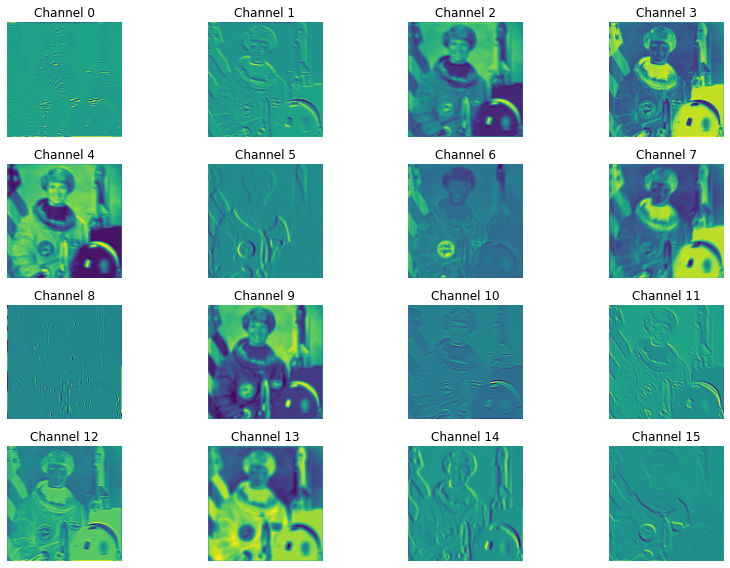

In [87]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image

# Load a pretrained model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()  # inference mode

# Choose a layer to visualize
layer_to_hook = model.conv1  # First conv layer

# Load and preprocess an image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # shape: (3, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
from skimage import data
from PIL import Image
import numpy as np

# Load the astronaut image and convert to PIL format
astronaut_np = data.astronaut()  # shape: (H, W, 3), uint8
img = Image.fromarray(astronaut_np)
input_tensor = transform(img).unsqueeze(0)  # shape: (1, 3, H, W)

# Hook to capture output of the layer
features = []

def hook_fn(module, input, output):
    features.append(output.detach().squeeze(0))  # remove batch dim

handle = layer_to_hook.register_forward_hook(hook_fn)

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

handle.remove()

# Plot feature maps
feature_maps = features[0]  # shape: (C, H, W)
num_channels = feature_maps.shape[0]

# Plot the first N feature maps
N = 16
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.subplot(4, 4, i + 1)
    plt.imshow(feature_maps[i].cpu(), cmap='viridis')
    plt.title(f"Channel {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In Pytorch we use a convolutional layer as follows:

In [92]:
# Define a Conv2d layer:
#  - 1 input channel
#  - 1 output channel
#  - 3x3 kernel
#  - stride 1
#  - no padding
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)

### Training a Convolutional Layer
In order to integrate a convolutional layer into the optimization scheme of neural networks by means of backpropagation, we need to derive the derivative of the convolution operation. Luckily, this is pretty simple, since convolutions are just linear functions after all. For example, consider the following convolution operation:
\begin{align*}
\begin{pmatrix}
X_{11}& X_{12} & X_{13}\\
X_{21}& X_{22} & X_{23}\\
X_{31}& X_{32} & X_{33}
\end{pmatrix}
\star
\begin{pmatrix}
K_{11} & K_{12}\\
K_{21} & K_{22}
\end{pmatrix}
= 
\begin{pmatrix}
O_{11} & O_{12}\\
O_{21} & O_{22}
\end{pmatrix}
\end{align*}
This convolution operation is equivalent to the following matrix multiplication:
\begin{align*}
\underbrace{
\begin{pmatrix}
K_{11}&K_{12} & 0      & K_{21} & K_{22} & 0      & 0      & 0      & 0\\
0     &K_{11} & K_{12} & 0      & K_{21} & K_{22} & 0      & 0      & 0\\
0     &0      & 0      & K_{11} & K_{12} & 0      & K_{21} & K_{22} & 0\\
0     &0      & 0      & 0      & K_{11} & K_{12} & 0      & K_{21} & K_{22}
\end{pmatrix}}_{=A}
\underbrace{
\begin{pmatrix}
X_{11}\\ X_{12}\\ X_{13}\\
X_{21}\\ X_{22} \\ X_{23}\\
X_{31}\\ X_{32} \\ X_{33}
\end{pmatrix}}_{=\mathrm{vec}(A)}
= 
\underbrace{
\begin{pmatrix}
O_{11} \\ O_{12}\\
O_{21} \\ O_{22}
\end{pmatrix}}_{=\mathrm{vec}(O)}
\end{align*}
This relationship helps us determining the Jacobian of a convolutional layer when we need to backpropagate through it. In this case, $X$ is the output of the previous hidden layer and we have 
\begin{align*}
\frac{\partial \mathrm{vec}(O)}{\partial \mathrm{vec}(X)} = A^\top 
\end{align*}
Hence, by the chain rule, we compute for the Jacobian subject to a weight $w$ as
\begin{align*}
\frac{\partial )}{\partial w} = \frac{\partial \mathrm{vec}(O)}{\partial \mathrm{vec}(X)}\frac{\partial \mathrm{vec}(X)}{\partial w} = A^\top\frac{\partial \mathrm{vec}(X)}{\partial w} 
\end{align*}
The multiplication with $A^\top$ is performing an operation on the inner derivative $\frac{\partial \mathrm{vec}(X)}{\partial w} $ that is called **transposed convolution**. 
If we want to compute the partial derivative subject to a kernel element, then we can better use the definition of the convolution. Here, we compute the partial derivative for the vanilla convolution with padding=0 and stride=1:
\begin{align*}
\frac{\partial O_{ij}}{\partial K_{pq}} = \frac{\partial O_{ij}}{\partial K_{pq}} \sum_{i_k=0}^{k-1}\sum_{j_k=0}^{k-1} X_{i+i_k,j+j_k}K_{i_k,j_k} = X_{i+p,j+q}
\end{align*}

### Inductive Bias
If a convolution is just an affine function, what does it bring to use convolutional layers instead of fully connected ones? Every relationship that can be learned by a convolutional layer, can also be learned by an a dense one. The answer is that it can be very beneficial to restrict the parameter search space by applying assumptions about what kind of relationships we deem important for the task at hand. This introduces the topic of the inductive bias.    

CNNs have very strong inductive biases, that are assumptions about how data should be processed and how it is structured. These assumptions made the accurate automatic processing of images with machine learning possible, and hence, the inductive bias of CNNs is a core topic in theory and practice. For example, the introduction of convolution meant that CNNs don't need to learn from scratch that an edge is still an edge if it moves 10 pixels to the right.

Generally, an inductive bias is a built-in assumption that guides a learning algorithm toward certain types of solutions. It describes mainly design choices that push a model towards specific outputs that we deem more useful. For example, the assumption that a regression model only needs a subset of the available feature is an inductive bias in sparse regression models. 

In convolutional neural networks (CNNs), the inductive biases are:

 - Locality: Nearby pixels form patterns that may be useful for the task.

 - Translation equivariance: If the input shifts, the output shifts accordingly (i.e., features are detected regardless of position).

 - Parameter sharing: The same filter (set of weights) is used across the whole image, reducing the number of parameters.

These assumptions make CNNs particularly effective for tasks with grid-structured data (e.g., images, video, audio spectrograms).